In [2]:
! pip install pyrealsense2
import pyrealsense2 as rs
import numpy as np
import cv2
import time
import math


#import all the libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import os
import PIL
import glob

In [52]:
# This part of the code takes the picture. takes some time (around 6 seconds)
# It will probably not work online
# We have to set the webcam manually if several webcams are attached (change the argument from VideoCapture() with an integer between 2 and 7 (usually it is 4 or 5))
cap = cv2.VideoCapture(5)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")


cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
ret, frame = cap.read()
frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

#cv2.imwrite("myimage.jpg", frame) 

cap.release()
cv2.destroyAllWindows()

[ WARN:0] global ../modules/videoio/src/cap_gstreamer.cpp (935) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


In [64]:
pipeline = rs.pipeline()
config = rs.config()

config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 6)
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 6)

profile = pipeline.start(config)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()

# We will be removing the background of objects more than
#  clipping_distance_in_meters meters away
clipping_distance_in_meters = 1.5 
clipping_distance = clipping_distance_in_meters / depth_scale

align_to = rs.stream.color
align = rs.align(align_to)

frames = pipeline.wait_for_frames()

aligned_frames = align.process(frames)
aligned_depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

depth_image = np.asanyarray(aligned_depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())


# Remove background - Set pixels further than clipping_distance to grey
grey_color = 153
depth_image_3d = np.dstack((depth_image,depth_image,depth_image)) #depth image is 1 channel, color is 3 channels
bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)

# Render images
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
images = np.hstack((bg_removed, depth_colormap))
cv2.namedWindow('Align Example', cv2.WINDOW_AUTOSIZE)

# Filename 
#path = 'C:/Users/aatefi2/Desktop/Intel real sense/Codes/'
imageName1 = str(time.strftime("%Y_%m_%d_%H_%M_%S")) +  '_Color.jpg'
#imageName2 = str(time.strftime("%Y_%m_%d_%H_%M_%S")) +  '_Depth.jpg'
#imageName3 = str(time.strftime("%Y_%m_%d_%H_%M_%S")) +  '_bg_removed.jpg'
#imageName4 = str(time.strftime("%Y_%m_%d_%H_%M_%S")) +  '_ColorDepth.jpg'
#imageName5 = str(time.strftime("%Y_%m_%d_%H_%M_%S")) +  '_DepthColormap.jpg'

# Saving the image 

cv2.imwrite(imageName1, color_image) 
"""
cv2.imwrite(imageName2, depth_image) 
cv2.imwrite(imageName3, images) 
cv2.imwrite(imageName4, bg_removed )
cv2.imwrite(imageName5, depth_colormap )
"""
print(imageName1)


key = cv2.waitKey(1)
# Press esc or 'q' to close the image window
cv2.destroyAllWindows()

pipeline.stop()

2022_11_15_21_17_12_Color.jpg


/tmp/ipykernel_16434/755655765.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')


(720, 1280)
(720, 1280)
(112, 112)
(28, 28)


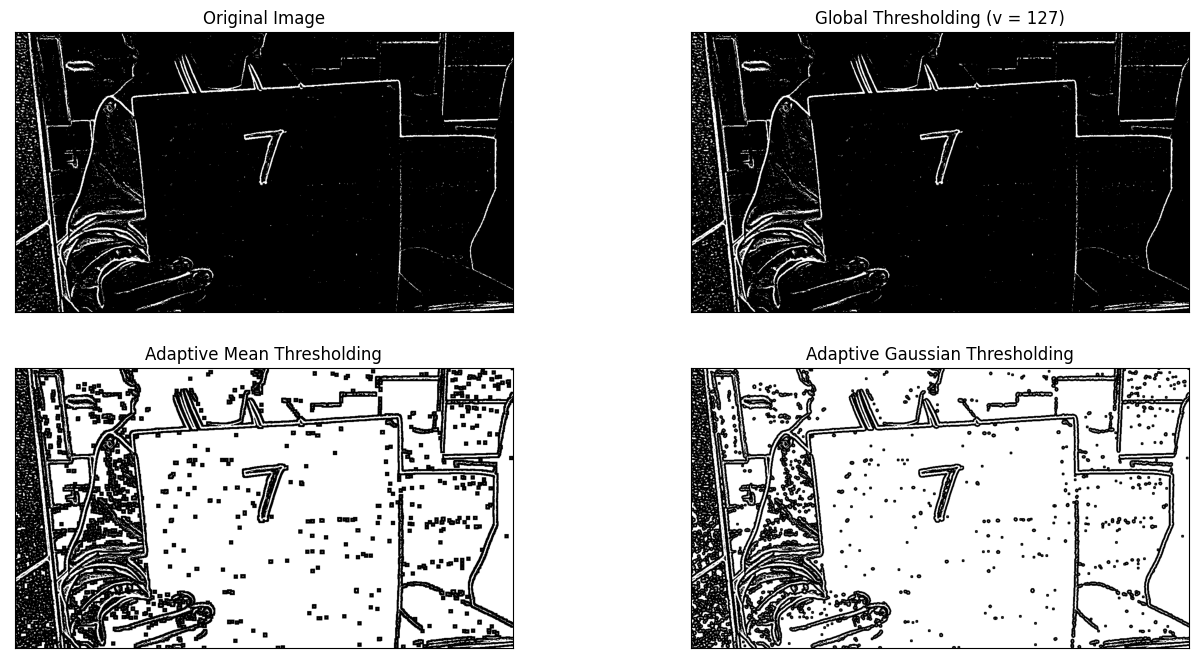

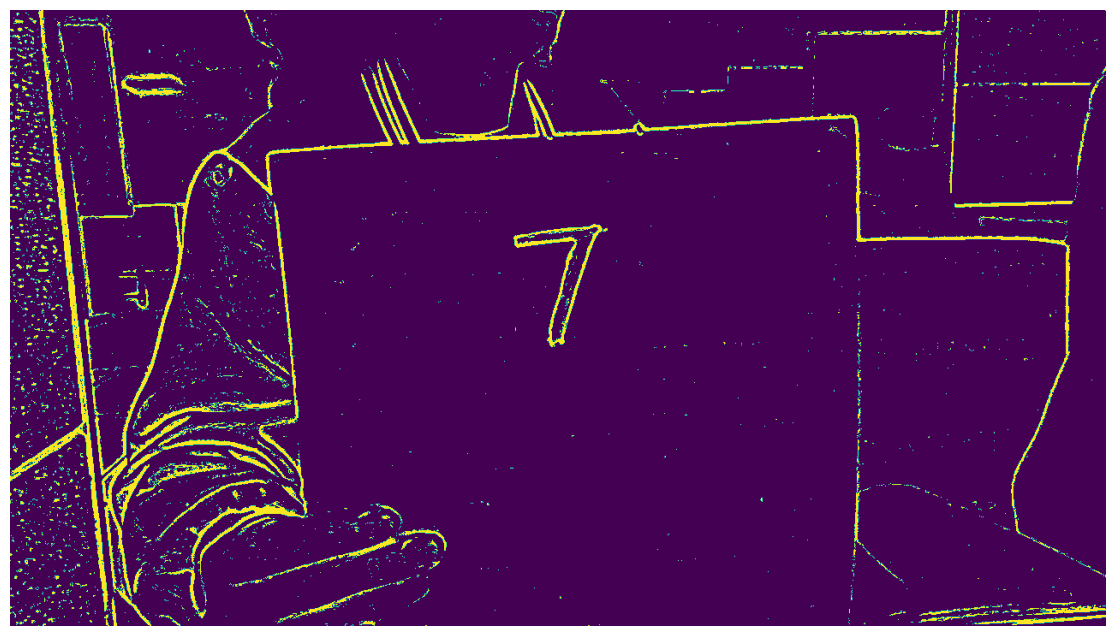

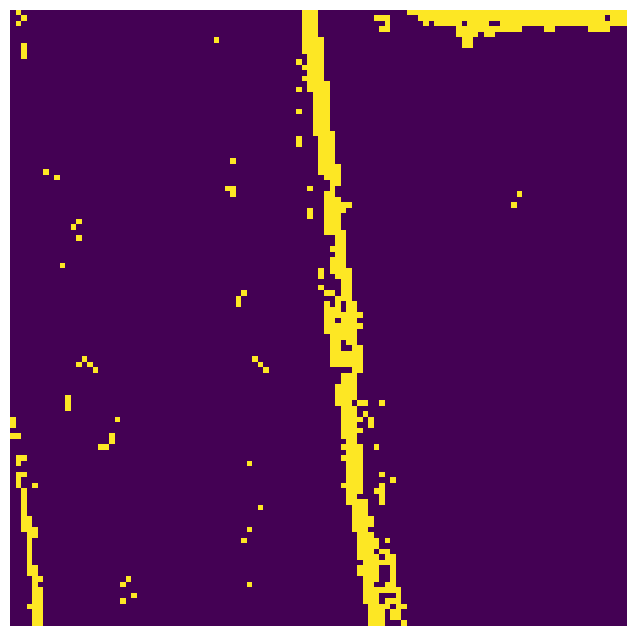

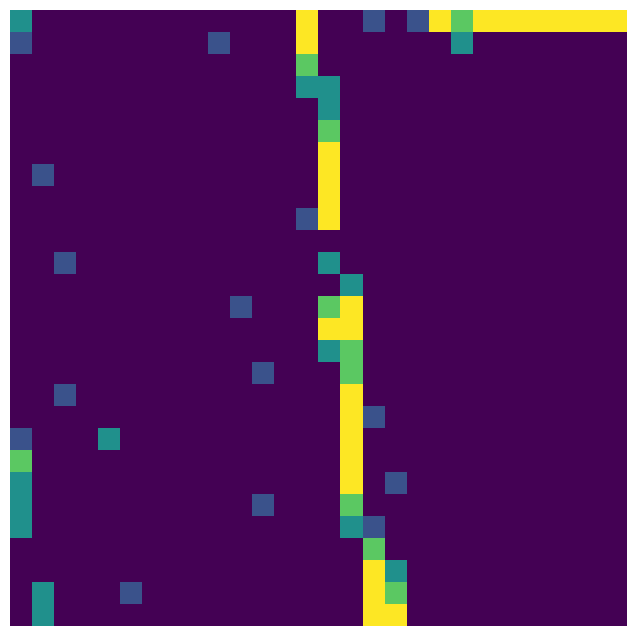

In [75]:
#convert image to black and white, assuming that it is a dark number on a light background
image = color_image
cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

#show the picture taken
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(color_image)

image = cv2.medianBlur(image,5)
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image=grayImage
thresholded_image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
image  = thresholded_image
#image=blackAndWhiteImage
image = cv2.bitwise_not(image)

# This part only is for visualization purpose, thresholds comparison
ret,th1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)

th3 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [image, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

print(image.shape)

#show the entire processed picture
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(image)

#take the part of the picture which contains the number (it just takes the hard coded coordinates regardless of the picture, cause most of the time the number is gonna be in the middle)
tempIM=np.asarray(image)
print(tempIM.shape)
woIM=tempIM[96:208,70:182] #you might have to change these numbers for getting the number in. It is important that their distance is always 112. 

#show the selected part of the image
print(woIM.shape)
plt.figure(figsize=(50,8))
plt.axis('off')
plt.imshow(woIM)

#downscale the image
woIMre=cv2.resize(src=woIM, dsize=(28,28))
print(woIMre.shape)

#show the downscaled image
plt.figure(figsize=(50,8))
plt.axis('off')
plt.imshow(woIMre)
#print(woIMre)
save=woIMre


In [7]:
#define the neuronal network
class CNN(nn.Module):
  def __init__(self, in_size, out_size):
    super(CNN, self).__init__()
    #784
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)                  
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
    self.fc1 = nn.Linear(32 * 7 * 7, 400) 
    self.fc2 = nn.Linear(400, 200)
    self.fc3 = nn.Linear(200, 10)

   

  def forward(self, x):
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    out = out.view(-1,32*7*7)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)   

    return out


In [9]:
#load the trained network. The command: Netdata=torch.load('MNISTCNNcheckpoint.pth', map_location=torch.device('cpu')) 
#is where you select the file with the data you wanna load. Make sure the file has the name it has in the command and is in the same folder as this program
#I uploaded the file I used in this code, it is from the MNIST CNN in the dropbox. I only trained for 3 epochs, feel free to you use you own longer trained one!

net = CNN(28*28, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
Netdata=torch.load('MNISTCNNcheckpoint.pth', map_location=torch.device('cpu'))
net.load_state_dict(Netdata)

<All keys matched successfully>

In [10]:
net.eval

<bound method Module.eval of CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)>

In [11]:
woIMre=save #only important if running the next cell several times. then just run this every time before to make sure it processes the correct image

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/alaborie/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_16434/660391754.py", line 1, in <module>
    woIMre=save #only important if running the next cell several times. then just run this every time before to make sure it processes the correct image
NameError: name 'save' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/alaborie/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/alaborie/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1112, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/alaborie/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1006, in s

In [ ]:
#print(woIMre)

#reshaping the input data so the network can process it.
woIMre=np.reshape(woIMre, [1, 28, 28])

'''I use 255 as the norm because the tensors of the pictures my camera takes contain numbers from 0 to 255, but the CNN only works well for
matrixes with numbers im between 0 and 1. so you might need to change this depending on you camera, just make sure the matrix immediently before you
put into the networks does not contain numbers higher than one and no 'nan' values'''

#norm=np.linalg.norm(woIMre, axis=1)
norm=255
woIMre=woIMre/norm
#print(woIMre)

#transforming the input into a pytorch datatype so the network can process it

woIMre=torch.tensor(woIMre)
woIMre=woIMre.float() #network wants float, so we give it float
out=net.forward(woIMre) #calculating the output
out=torch.argmax(out) #here we check which number the network actually predicted
print(out)